In [1]:
import numpy as np
from qiskit import QuantumCircuit, Aer
from qiskit.visualization import plot_histogram

In [2]:
# Import qiskit machine learning parameters
from qiskit.circuit import ParameterVector, Parameter

# Number of qubits needed to model real distribution
REAL_NQUBITS = 2
real_circuit = QuantumCircuit(REAL_NQUBITS)

# R(z)
r_weight = Parameter('z')
for i in range(REAL_NQUBITS):
    real_circuit.rx(r_weight.arcsin(), i)
    real_circuit.rz(r_weight.arccos(), i)

# G(θ)
real_weights = [2.48, 2.52, 2.0]
real_circuit.ry(real_weights[0], 0)
real_circuit.ry(real_weights[1], 1)
real_circuit.rxx(real_weights[2], 0, 1)

real_circuit.draw()

┌─────────────┐┌─────────────┐┌──────────┐┌─────────┐
q_0: ┤ Rx(asin(z)) ├┤ Rz(acos(z)) ├┤ Ry(2.48) ├┤0        ├
     ├─────────────┤├─────────────┤├──────────┤│  Rxx(2) │
q_1: ┤ Rx(asin(z)) ├┤ Rz(acos(z)) ├┤ Ry(2.52) ├┤1        ├
     └─────────────┘└─────────────┘└──────────┘└─────────┘

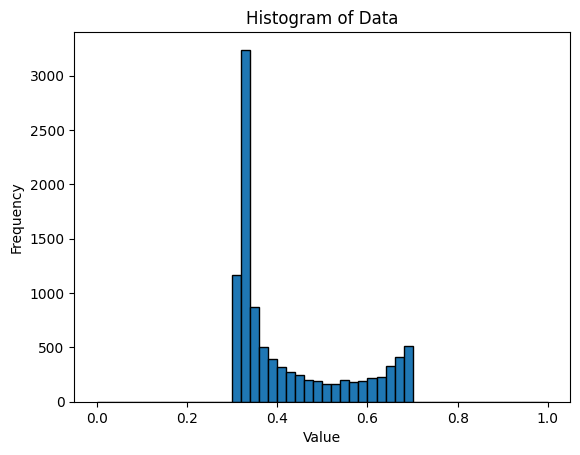

In [3]:
import random
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector

# real distribution
NUM = 10000
real_z = [random.uniform(-1, 1) for _ in range(NUM)]
real_x = []
for i in range(NUM):
    real_out = real_circuit.assign_parameters({r_weight: real_z[i]})
    # measure the first qubit
    state_probs = Statevector(real_out).probabilities() 
    real_x.append(np.sum(state_probs[0b10:]))

plt.hist(real_x, bins=np.arange(0, 1+0.02, 0.02), edgecolor='black')

plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

In [4]:
GAN_NQUBITS = 2

# R(z)
R_weight = Parameter('z')
generator = QuantumCircuit(GAN_NQUBITS)
for i in range(GAN_NQUBITS):
    generator.rx(R_weight.arcsin(), i)
    generator.rz(R_weight.arccos(), i)

# G(θ)
gen_weights = ParameterVector('θ_g', 3)
generator.ry(gen_weights[0], 0)
generator.ry(gen_weights[1], 1)
generator.rxx(gen_weights[2], 0, 1)

generator.draw()

┌─────────────┐┌─────────────┐┌────────────┐┌──────────────┐
q_0: ┤ Rx(asin(z)) ├┤ Rz(acos(z)) ├┤ Ry(θ_g[0]) ├┤0             ├
     ├─────────────┤├─────────────┤├────────────┤│  Rxx(θ_g[2]) │
q_1: ┤ Rx(asin(z)) ├┤ Rz(acos(z)) ├┤ Ry(θ_g[1]) ├┤1             ├
     └─────────────┘└─────────────┘└────────────┘└──────────────┘

In [5]:
DIS_NQUBITS = 3
E_weight = Parameter('x')
discriminator = QuantumCircuit(DIS_NQUBITS)

# E(x)
for i in range(DIS_NQUBITS):
    discriminator.ry(E_weight.arcsin(), i)
    discriminator.rz(E_weight.arccos(), i)

# D(θ)
disc_weights = ParameterVector('θ_d', 5)
for i in range(DIS_NQUBITS):
    discriminator.rz(disc_weights[0], i)
    discriminator.ry(disc_weights[1], i)
    discriminator.rz(disc_weights[2], i)

discriminator.cp(disc_weights[3], 0, 1)
discriminator.cp(disc_weights[3], 1, 2)
discriminator.cp(disc_weights[3], 2, 0)

for i in range(DIS_NQUBITS):
    discriminator.rx(disc_weights[4], i)

discriminator.draw()

┌─────────────┐┌─────────────┐┌────────────┐┌────────────┐┌────────────┐»
q_0: ┤ Ry(asin(x)) ├┤ Rz(acos(x)) ├┤ Rz(θ_d[0]) ├┤ Ry(θ_d[1]) ├┤ Rz(θ_d[2]) ├»
     ├─────────────┤├─────────────┤├────────────┤├────────────┤├────────────┤»
q_1: ┤ Ry(asin(x)) ├┤ Rz(acos(x)) ├┤ Rz(θ_d[0]) ├┤ Ry(θ_d[1]) ├┤ Rz(θ_d[2]) ├»
     ├─────────────┤├─────────────┤├────────────┤├────────────┤├────────────┤»
q_2: ┤ Ry(asin(x)) ├┤ Rz(acos(x)) ├┤ Rz(θ_d[0]) ├┤ Ry(θ_d[1]) ├┤ Rz(θ_d[2]) ├»
     └─────────────┘└─────────────┘└────────────┘└────────────┘└────────────┘»
«                                         ┌────────────┐
«q_0: ─■───────────────────────■──────────┤ Rx(θ_d[4]) ├
«      │P(θ_d[3])              │          ├────────────┤
«q_1: ─■───────────■───────────┼──────────┤ Rx(θ_d[4]) ├
«                  │P(θ_d[3])  │P(θ_d[3]) ├────────────┤
«q_2: ─────────────■───────────■──────────┤ Rx(θ_d[4]) ├
«                                         └────────────┘

In [6]:
def sample_x():
    return real_x[random.randint(0, len(real_x)-1)]

def sample_z():
    return random.uniform(-1, 1)

In [7]:
# We'll use Statevector to retrieve statevector of given circuit
from qiskit.quantum_info import Statevector
import tensorflow as tf

NSAMPLE = 150
def generator_cost(gen_params, disc_params):
    cost = 0
    """Generator cost function for the optimizer to minimize."""
    # .numpy() method extracts numpy array from TF tensor
    for i in range(NSAMPLE):
        z = sample_z()
        curr_gen_params = np.append(z,
                            gen_params.numpy())
        gen_probs = Statevector(generator
                                .assign_parameters(curr_gen_params)
                               ).probabilities()
        x_fake = np.sum(gen_probs[0b10:])
        fake_disc_params = np.append(x_fake,
                            disc_params.numpy())
        fake_disc_probs = Statevector(discriminator
                                .assign_parameters(fake_disc_params)
                                ).probabilities()
        p_fake = np.sum(fake_disc_probs[0b100:])
        cost += -p_fake/NSAMPLE
    return cost

def discriminator_cost(gen_params, disc_params):
    """Discriminator cost function for the optimizer to minimize."""
    # .numpy() method extracts numpy array from TF tensor
    cost = 0
    for i in range(NSAMPLE):
        z = sample_z()
        x_real = sample_x()
        curr_gen_params = np.append(z,
                            gen_params.numpy())
        gen_probs = Statevector(generator
                                .assign_parameters(curr_gen_params)
                               ).probabilities()
        x_fake = np.sum(gen_probs[0b10:])
        fake_disc_params = np.append(x_fake,
                            disc_params.numpy())
        fake_disc_probs = Statevector(discriminator
                                .assign_parameters(fake_disc_params)
                                ).probabilities()
        p_fake = np.sum(fake_disc_probs[0b100:])
        real_disc_params = np.append(x_real,
                            disc_params.numpy())
        real_disc_probs = Statevector(discriminator
                                .assign_parameters(real_disc_params)
                                ).probabilities()
        p_real = np.sum(real_disc_probs[0b100:])
        cost += (p_fake - p_real)/NSAMPLE
    return cost

def calculate_kl_div(gen_params):
    num = 200
    x_fake = []
    for i in range(num):
        z = sample_z()
        curr_gen_params = np.append(z,
                                gen_params.numpy())
        gen_probs = Statevector(generator
                                .assign_parameters(curr_gen_params)
                                ).probabilities()
        x_f = np.sum(gen_probs[0b10:])
        x_fake.append(x_f)
    fake_hist, fake_bin_edges = np.histogram(x_fake, bins=np.arange(0, 1+0.02, 0.02), density=False)
    fake_hist = fake_hist / num
    
    x_real = [sample_x() for _ in range(num)]
    real_hist, real_bin_edges = np.histogram(x_real, bins=np.arange(0, 1+0.02, 0.02), density=False)
    real_hist = real_hist / num
    
    kl_div = 0
    for i in range(len(real_hist)):
        if np.isclose(real_hist[i], 0, atol=1e-8):
            continue
        if np.isclose(fake_hist[i], 0, atol=1e-8):
            kl_div +=  real_hist[i] * np.log(real_hist[i]) - real_hist[i] * np.log(1e-6)
        else:
            kl_div += (real_hist[i] * np.log(real_hist[i])
                 - real_hist[i] * np.log(fake_hist[i]))
    return kl_div

2023-12-02 16:40:24.432151: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 16:40:24.434445: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-02 16:40:24.464490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 16:40:24.464509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 16:40:24.465326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [8]:
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import Sampler
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123456

shots = 1000
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

# specify QNN to update generator weights
gen_qnn = SamplerQNN(circuit=generator,  # parameterized circuit
                     sampler=sampler,
                     # frozen input arguements (discriminator weights)
                     input_params=[generator.parameters[0]],
                     # differentiable weights (generator weights)
                     weight_params=generator.parameters[1:],
                     sparse=False, # returns sparse probability vector
                     )

# specify QNNs to update discriminator weights
disc_qnn = SamplerQNN(circuit=discriminator, # parameterized circuit
                       sampler=sampler,
                       # frozen input arguments (generator weights)
                       input_params=[discriminator.parameters[0]],
                       # differentiable weights (discrim. weights)
                       weight_params=discriminator.parameters[1:],
                       sparse=False, # get sparse probability vector
                       input_gradients=True
                       )

In [9]:
import tensorflow as tf
import pickle # to serialize and deserialize variables

N_GPARAMS = generator.num_parameters - 1
N_DPARAMS = discriminator.num_parameters - 1
# Initialize parameters
init_gen_params = np.random.uniform(low=-np.pi,
                                    high=np.pi,
                                    size=(N_GPARAMS,))
init_disc_params = np.random.uniform(low=-np.pi,
                                     high=np.pi,
                                     size=(N_DPARAMS,))
gen_params = tf.Variable(init_gen_params)
disc_params = tf.Variable(init_disc_params)

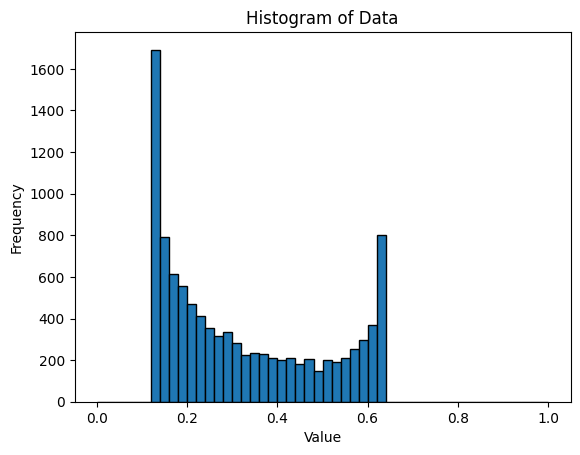

<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([2.81116952, 2.22441148, 2.5428824 ])>


In [10]:
init_z = [random.uniform(-1, 1) for _ in range(NUM)]
init_x = []
for i in range(NUM):
    init_out = generator.assign_parameters(np.insert(gen_params.numpy(), 0, real_z[i]))
    # measure the first qubit
    state_probs = Statevector(init_out).probabilities() 
    init_x.append(np.sum(state_probs[0b10:]))

plt.hist(init_x, bins=np.arange(0, 1+0.02, 0.02), edgecolor='black')

plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()
print(gen_params)

In [11]:
# Initialize Adam optimizer from Keras
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

In [12]:
# Initialize variables to track metrics while training
best_gen_params = tf.Variable(init_gen_params)
gloss = []
dloss = []
kl_div = []

In [13]:
TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. |"
print(TABLE_HEADERS)
Ns = 200
for epoch in range(120):
    #--- Quantum discriminator parameter updates ---#
    D_STEPS = 5 # N discriminator updates per generator update
    for disc_train_step in range(D_STEPS):
        # Partial derivatives wrt θ_D
        grad_dcost = tf.zeros(shape=(N_DPARAMS,), dtype=tf.float64)
        for i in range(Ns):
            z = sample_z()
            x_real = sample_x()
            gen_out = generator.assign_parameters(np.insert(gen_params, 0, z))
            # measure the last qubit
            x_fake = Statevector(gen_out).probabilities()
            x_fake = np.sum(x_fake[0b10:])
            d_fake = disc_qnn.backward([x_fake], disc_params)[1][0, 0b100:]
            d_fake = np.sum(d_fake, axis=0)
            d_real = disc_qnn.backward([x_real], disc_params)[1][0, 0b100:]
            d_real = np.sum(d_real, axis=0)
            # Recall Cost_D structure
            grad_dcost += tf.convert_to_tensor([(d_fake[i] - d_real[i])/Ns for i in range(N_DPARAMS)], dtype=tf.float64)
        discriminator_optimizer.apply_gradients(zip([grad_dcost],
                                                [disc_params]))

        if disc_train_step % D_STEPS == 0:
            disc_cost = discriminator_cost(gen_params, disc_params)
            dloss.append(disc_cost)

    #--- Quantum generator parameter updates ---#
    for gen_train_step in range(1):
        # Compute partial derivatives of prob(fake|true) wrt each
        grads = tf.zeros(shape=(N_GPARAMS,), dtype=tf.float64)
        for i in range(Ns):
            z = sample_z()
            gen_out = generator.assign_parameters(np.insert(gen_params, 0, z))
            # measure the last qubit
            x_fake = Statevector(gen_out).probabilities()
            x_fake = np.sum(x_fake[0b10:])
            grad_gen = gen_qnn.backward([z], gen_params)[1][0, 0b10:]
            grad_gen = np.sum(grad_gen, axis=0)
            grad_disc= disc_qnn.backward([x_fake], disc_params)[0][0, 0b100:]
            grad_disc = np.sum(grad_disc, axis=0)
            grad = -grad_gen*grad_disc/Ns
            grads += tf.convert_to_tensor(grad, dtype=tf.float64)
        # Update gen params with gradient
        generator_optimizer.apply_gradients(zip([grads], [gen_params]))
        gen_cost = generator_cost(gen_params, disc_params)
        gloss.append(gen_cost)

    #--- Track KL and save best performing generator weights ---#
    # Create test circuit with updated gen parameters
    current_kl = calculate_kl_div(gen_params)
    kl_div.append(current_kl)
    if np.min(kl_div) == current_kl:
        # New best
        # serialize & deserialize to simply ensure zero links
        best_gen_params = pickle.loads(pickle.dumps(gen_params))
    if epoch % 1 == 0:
        # print table every epochs
        for header, val in zip(TABLE_HEADERS.split('|'),
                              (epoch, gloss[-1], dloss[-1], kl_div[-1])):
            print(f"{val:.3g} ".rjust(len(header)), end="|")
        print()

Epoch | Generator cost | Discriminator cost | KL Div. |
    0 |         -0.724 |               0.03 |    2.68 |
    1 |         -0.748 |            0.00395 |    3.19 |
    2 |         -0.742 |            -0.0159 |    2.58 |
    3 |         -0.714 |            -0.0341 |    2.55 |
    4 |         -0.698 |            -0.0265 |     2.6 |
    5 |           -0.7 |            -0.0415 |    2.71 |
    6 |         -0.713 |            -0.0351 |    2.15 |
    7 |         -0.713 |            -0.0309 |    1.84 |
    8 |          -0.71 |            -0.0184 |    1.15 |
    9 |         -0.674 |             -0.028 |    1.96 |
   10 |         -0.656 |            -0.0382 |     1.1 |
   11 |         -0.645 |            -0.0204 |    1.14 |
   12 |         -0.633 |            -0.0313 |    1.12 |
   13 |          -0.63 |           -0.00756 |    1.31 |
   14 |         -0.662 |            -0.0125 |    1.27 |
   15 |         -0.669 |            -0.0165 |    1.35 |
   16 |         -0.703 |           -0.00336 |   

KeyboardInterrupt: 

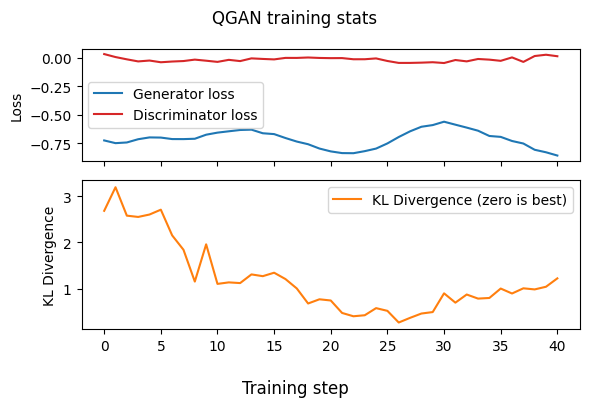

In [14]:
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)",
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout();

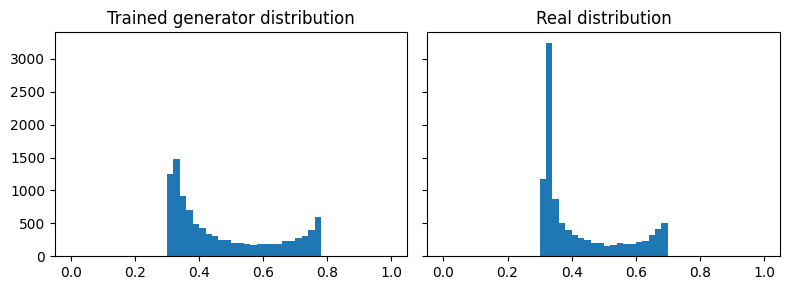

In [15]:
# fake distribution
fake_x = []
for i in range(NUM):
    z = sample_z()
    curr_gen_params = np.append(z,
                            best_gen_params.numpy())
    gen_probs = Statevector(generator
                            .assign_parameters(curr_gen_params)
                            ).probabilities()
    x_fake = np.sum(gen_probs[0b10:])
    fake_x.append(x_fake)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), sharey=True)
ax1.hist(fake_x, bins=np.arange(0, 1+0.02, 0.02))
ax1.set_title("Trained generator distribution")
ax2.hist(real_x, bins=np.arange(0, 1+0.02, 0.02))
ax2.set_title("Real distribution")
fig.tight_layout()

In [16]:
print(best_gen_params)

<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([2.45016756, 1.92672039, 2.16549042])>
